Data Loading: Empty DataFrame
Columns: []
Index: []
Data Period: 2022-06-30 00:00:00 ~ 2025-06-30 00:00:00
Average Monthly Return: 0.0764 (91.62%/year)
Current Volatility: 69.74%


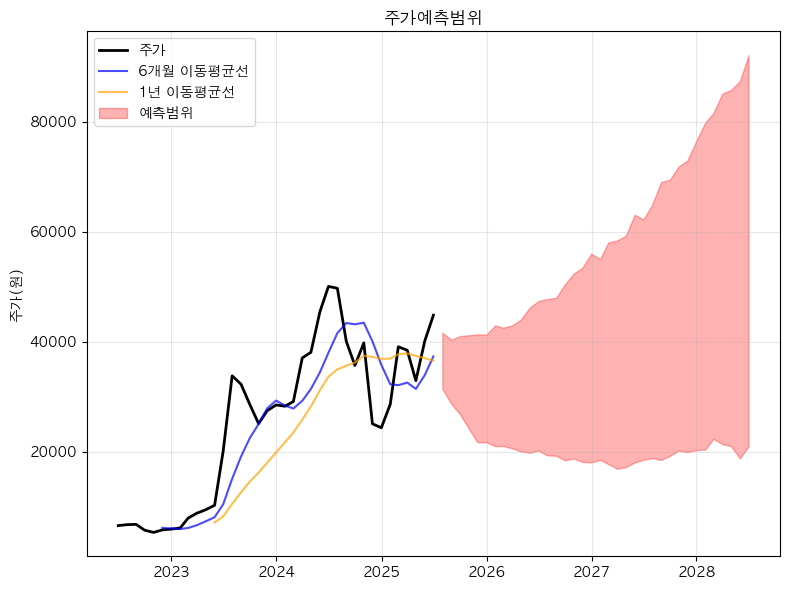


Empty DataFrame
Columns: []
Index: [] Advanced Forecast Analysis Results
Current Price: 44,842 KRW
Max Drawdown (Historical): -51.4%
95% VaR (Monthly): -26.4%

--- 6 Months Forecast ---
    ARIMA Basic:   44,914 KRW (  +0.2%)
 ARIMA Adjusted:   44,914 KRW (  +0.2%)
 Mean Reversion:   39,216 KRW ( -12.5%)
       Ensemble:   46,831 KRW (  +4.4%)
Confidence Band:   21,730 KRW ~  151,150 KRW

--- 12 Months Forecast ---
    ARIMA Basic:   44,914 KRW (  +0.2%)
 ARIMA Adjusted:   44,914 KRW (  +0.2%)
 Mean Reversion:   35,237 KRW ( -21.4%)
       Ensemble:   49,044 KRW (  +9.4%)
Confidence Band:   20,211 KRW ~  280,683 KRW

--- 24 Months Forecast ---
    ARIMA Basic:   44,914 KRW (  +0.2%)
 ARIMA Adjusted:   44,914 KRW (  +0.2%)
 Mean Reversion:   30,435 KRW ( -32.1%)
       Ensemble:   59,343 KRW ( +32.3%)
Confidence Band:   18,535 KRW ~  918,717 KRW

--- 36 Months Forecast ---
    ARIMA Basic:   44,914 KRW (  +0.2%)
 ARIMA Adjusted:   44,914 KRW (  +0.2%)
 Mean Reversion:   28,034 KRW ( -3

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pykrx import stock
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

stock_code = "007660"

class AdvancedStockPredictor:
    def __init__(self, code=stock_code):
        self.code = code
        self.name = stock.get_market_ticker_name(code)
        self.df = None
        self.df_monthly = None
        self.returns = None
        
    def load_data(self, start_date="2022-06-30", end_date="2025-06-29"):
        """데이터 로드 및 전처리"""
        print(f"Data Loading: {self.name}")
        self.df = stock.get_market_ohlcv_by_date(start_date, end_date, self.code)
        self.df_monthly = self.df['종가'].resample('M').mean().interpolate()
        
        # Calculate Returns
        self.returns = self.df_monthly.pct_change().dropna()
        
        # Calculate Volatility (12-month rolling)
        self.volatility = self.returns.rolling(window=12).std() * np.sqrt(12)
        
        print(f"Data Period: {self.df_monthly.index[0]} ~ {self.df_monthly.index[-1]}")
        print(f"Average Monthly Return: {self.returns.mean():.4f} ({self.returns.mean()*12:.2%}/year)")
        print(f"Current Volatility: {self.volatility.iloc[-1]:.2%}")
        
    def detect_regime_changes(self):
        """주가 추세 변화 감지"""
        # 단순 이동평균을 이용한 추세 판단
        ma_short = self.df_monthly.rolling(window=6).mean()
        ma_long = self.df_monthly.rolling(window=12).mean()
        
        # 추세 신호 생성
        trend_signal = np.where(ma_short > ma_long, 1, -1)  # 1: 상승, -1: 하락
        
        # 추세 변화점 찾기
        trend_changes = np.where(np.diff(trend_signal) != 0)[0]
        
        return trend_signal, trend_changes, ma_short, ma_long
    
    def calculate_downside_risk(self):
        """하방 위험 계산"""
        # 음수 수익률만 추출 (하락)
        negative_returns = self.returns[self.returns < 0]
        
        # Value at Risk (VaR) 계산 (95% 신뢰구간)
        var_95 = np.percentile(negative_returns, 5) if len(negative_returns) > 0 else 0
        
        # 최대 손실 (Maximum Drawdown)
        cumulative_returns = (1 + self.returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return var_95, max_drawdown, drawdown
    
    # def arima_with_volatility_adjustment(self, steps=12):
    def arima_with_volatility_adjustment(self, steps=36):
        """변동성을 고려한 ARIMA 예측"""
        # 기본 ARIMA 모델
        model = ARIMA(self.df_monthly, order=(1, 1, 1))
        model_fit = model.fit()
        
        # 기본 예측
        forecast = model_fit.forecast(steps=steps)
        forecast_se = model_fit.forecast(steps=steps, return_conf_int=True)[1]
        
        # 현재 변동성 수준
        current_volatility = self.volatility.iloc[-1]
        historical_volatility = self.volatility.mean()
        
        # 변동성이 평균보다 높으면 하방 위험 증가
        volatility_adjustment = current_volatility / historical_volatility
        
        # 하방 위험 조정
        adjusted_forecast = forecast.copy()
        if volatility_adjustment > 1.2:  # 변동성이 20% 이상 높으면
            # 점진적으로 하향 조정
            decline_factor = np.linspace(1.0, 0.85, steps)  # 최대 15% 하향 조정
            adjusted_forecast = forecast * decline_factor
            
        return forecast, adjusted_forecast, forecast_se
    
    def monte_carlo_simulation(self, steps=36, simulations=1000):
        """몬테카를로 시뮬레이션"""
        current_price = self.df_monthly.iloc[-1]
        mean_return = self.returns.mean()
        std_return = self.returns.std()
        
        # 시뮬레이션 결과 저장
        simulation_results = np.zeros((simulations, steps))
        
        for i in range(simulations):
            prices = [current_price]
            for j in range(steps):
                # 정규분포에서 수익률 샘플링
                random_return = np.random.normal(mean_return, std_return)
                next_price = prices[-1] * (1 + random_return)
                prices.append(next_price)
            simulation_results[i] = prices[1:]
        
        # 통계량 계산
        percentiles = np.percentile(simulation_results, [5, 25, 50, 75, 95], axis=0)
        
        return simulation_results, percentiles
    
    # def mean_reversion_model(self, steps=12):
    def mean_reversion_model(self, steps=36):
        """평균 회귀 모델"""
        # 장기 평균 (5년)
        long_term_mean = self.df_monthly.tail(60).mean()
        current_price = self.df_monthly.iloc[-1]
        
        # 평균 회귀 속도 (반감기 12개월 가정)
        half_life = 12
        reversion_speed = np.log(2) / half_life
        
        # 평균 회귀 예측
        future_dates = pd.date_range(start=self.df_monthly.index[-1] + pd.DateOffset(months=1), 
                                   periods=steps, freq='M')
        
        mean_reversion_forecast = []
        for t in range(1, steps + 1):
            # 시간에 따른 평균 회귀
            forecasted_price = long_term_mean + (current_price - long_term_mean) * np.exp(-reversion_speed * t)
            mean_reversion_forecast.append(forecasted_price)
        
        return pd.Series(mean_reversion_forecast, index=future_dates)

    # def comprehensive_forecast(self, steps=12):
    def comprehensive_forecast(self, steps=36):
        """종합 예측 (여러 모델 결합)"""
        # 각 모델별 예측
        arima_forecast, arima_adj_forecast, arima_se = self.arima_with_volatility_adjustment(steps)
        mc_results, mc_percentiles = self.monte_carlo_simulation(steps)
        mr_forecast = self.mean_reversion_model(steps)
        
        # 미래 날짜 생성
        future_dates = pd.date_range(start=self.df_monthly.index[-1] + pd.DateOffset(months=1), 
                                   periods=steps, freq='M')
        
        # 앙상블 예측 (가중 평균)
        ensemble_forecast = (
            0.5 * arima_adj_forecast +  # ARIMA (변동성 조정) 50%
            0.2 * mc_percentiles[2] +   # 몬테카를로 중앙값 20%
            0.3 * mr_forecast          # 평균 회귀 30%
        )
        
        return {
            'dates': future_dates,
            'arima_basic': pd.Series(arima_forecast, index=future_dates),
            'arima_adjusted': pd.Series(arima_adj_forecast, index=future_dates),
            'monte_carlo': mc_percentiles,
            'mean_reversion': mr_forecast,
            'ensemble': pd.Series(ensemble_forecast, index=future_dates)
        }
    
    def plot_comprehensive_analysis(self):
        """종합 분석 시각화"""
        # 예측 실행
        forecasts = self.comprehensive_forecast()
        trend_signal, trend_changes, ma_short, ma_long = self.detect_regime_changes()
        var_95, max_drawdown, drawdown = self.calculate_downside_risk()
        
        # 시각화
        fig, ax1 = plt.subplots(figsize=(8, 6))
        # fig.suptitle(f'{self.name} Advanced Stock Prediction Analysis', fontsize=16, fontweight='bold')
        
        # 1. Comprehensive Forecast Comparison
        # ax1 = axes[0]
        ax1.plot(self.df_monthly.index, self.df_monthly.values, label='주가', color='black', linewidth=2)
        ax1.plot(ma_short.index, ma_short.values, label='6개월 이동평균선', alpha=0.7, color='blue')
        ax1.plot(ma_long.index, ma_long.values, label='1년 이동평균선', alpha=0.7, color='orange')
        
        # Forecast Results  
        # ax1.plot(forecasts['dates'], forecasts['ensemble'], label='주가예측선', linewidth=3, color='red')

        # percentiles = np.percentile(simulation_results, [5, 25, 50, 75, 95], axis=0)
        ax1.fill_between(forecasts['dates'], forecasts['monte_carlo'][1], forecasts['monte_carlo'][0], 
                        alpha=0.3, color='red', label='예측범위')
        
        ax1.set_title('주가예측범위')
        ax1.set_ylabel('주가(원)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 예측 결과 요약 출력
        self.print_forecast_summary(forecasts, var_95, max_drawdown)
    
    def print_forecast_summary(self, forecasts, var_95, max_drawdown):
        """예측 결과 요약 출력"""
        current_price = self.df_monthly.iloc[-1]
        
        print(f"\n{'='*60}")
        print(f"{self.name} Advanced Forecast Analysis Results")
        print(f"{'='*60}")
        print(f"Current Price: {current_price:,.0f} KRW")
        print(f"Max Drawdown (Historical): {max_drawdown:.1%}")
        print(f"95% VaR (Monthly): {var_95:.1%}")
        
        periods = [6, 12, 24, 36]
        for period in periods:
            if period <= len(forecasts['ensemble']):
                print(f"\n--- {period} Months Forecast ---")
                
                models = {
                    'ARIMA Basic': forecasts['arima_basic'].iloc[period-1],
                    'ARIMA Adjusted': forecasts['arima_adjusted'].iloc[period-1],
                    'Mean Reversion': forecasts['mean_reversion'].iloc[period-1],
                    'Ensemble': forecasts['ensemble'].iloc[period-1]
                }
                
                for model_name, price in models.items():
                    change = ((price - current_price) / current_price) * 100
                    print(f"{model_name:>15}: {price:>8,.0f} KRW ({change:>+6.1f}%)")
                
                # Monte Carlo Intervals
                mc_low = forecasts['monte_carlo'][0][period-1]
                mc_high = forecasts['monte_carlo'][4][period-1]
                print(f"{'Confidence Band':>15}: {mc_low:>8,.0f} KRW ~ {mc_high:8,.0f} KRW")

# Usage Example
if __name__ == "__main__":
    # Stock Code (025950: Dongsuh)
    predictor = AdvancedStockPredictor(stock_code)
    predictor.load_data()
    predictor.plot_comprehensive_analysis()

In [10]:
import pandas as pd

df = pd.read_csv("../corp_list.csv", encoding="utf-8", dtype={'종목코드':str})
df

,Unnamed: 0,회사명,corp_eng_name,종목코드
0,1946,한빛네트,"HanbitNet, Inc.",36720
1,1958,엔플렉스,"Nplex,Inc.",40130
2,1959,동서정보기술,"Dong Seo Information Technology Co., Ltd.",55000
3,2700,애드모바일,,32600
4,3772,리더컴,"LEADER COMM.Co.,Ltd",56140
...,...,...,...,...
3863,112572,더바이오메드,"THE BioMed Co., Ltd.",214610
3864,112573,나라소프트,"NARASOFT Co.,Ltd.",288490
3865,112574,아이티센피엔에스,"ITCENPNS CO.,LTD.",232830
3866,112575,원일티엔아이,"WONILTNI CO., LTD.",136150


In [11]:
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)

In [15]:
df2 = df.sort_values('회사명', ascending=False).drop("Unnamed: 0", axis=1).reset_index(drop=True)
df2

,회사명,corp_eng_name,종목코드
0,힘스,"HIMS CO., LTD.",238490
1,히든챔피언제1호기업인수목적,HiddenChampion 1st Special Purpose Acquisition...,123160
2,희훈디앤지,HEEHOON DESIGN & GLOBAL.CO.LTD,019640
3,희림,Heerim Architects & Planners,037440
4,흥아해운,"HEUNG-A SHIPPING CO.,LTD.",003280
...,...,...,...
3863,APS,APS Inc.,054620
3864,AK홀딩스,"AK Holdings, Inc.",006840
3865,AJ네트웍스,"AJ Networks Co.,Ltd.",095570
3866,3노드디지탈그룹유한공사,"3NODDigitalGroupCo.,Ltd.",900010


In [16]:
df2.to_csv("../corp_list.csv", index=False, encoding="utf-8-sig")

In [1]:
import pandas as pd
df2 = pd.read_csv("../corp_list.csv", dtype={'종목코드':str})
df2.head()

,회사명,corp_eng_name,종목코드
0,힘스,"HIMS CO., LTD.",238490
1,히든챔피언제1호기업인수목적,HiddenChampion 1st Special Purpose Acquisition...,123160
2,희훈디앤지,HEEHOON DESIGN & GLOBAL.CO.LTD,019640
3,희림,Heerim Architects & Planners,037440
4,흥아해운,"HEUNG-A SHIPPING CO.,LTD.",003280


In [ ]:
df2['is_defaulted'] = [1] + [0 for _ in range(df2.shape[0]-1)]
df2.tail()

,회사명,corp_eng_name,종목코드,is_defaulted
0,힘스,"HIMS CO., LTD.",238490,1
1,히든챔피언제1호기업인수목적,HiddenChampion 1st Special Purpose Acquisition...,123160,0
2,희훈디앤지,HEEHOON DESIGN & GLOBAL.CO.LTD,019640,0
3,희림,Heerim Architects & Planners,037440,0
4,흥아해운,"HEUNG-A SHIPPING CO.,LTD.",003280,0


In [3]:
df2.tail()

,회사명,corp_eng_name,종목코드,is_defaulted
3863,APS,APS Inc.,054620,0
3864,AK홀딩스,"AK Holdings, Inc.",006840,0
3865,AJ네트웍스,"AJ Networks Co.,Ltd.",095570,0
3866,3노드디지탈그룹유한공사,"3NODDigitalGroupCo.,Ltd.",900010,0
3867,3S,"3S KOREA CO., LTD",060310,0


In [4]:
df2.to_csv("../corp_list2.csv", index=False, encoding="utf-8-sig")